### Authenticating with the M2M API

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner).

In [1]:
username =''
token = ''

Optionally, you can handle authentication outside the notebook by setting up a .netrc file in your home directory and loading it with your bash profile. Open your terminal
```
$ touch .netrc
$ chmod 700 .netrc
$ vim .netrc

```
Add the following your your .netrc file:

```
machine ooinet.oceanobservatories.org
login OOIAPI-TEMPD1SPK4K0X
password TEMPCXL48ET2XT
```

Use your username and token. Save the file and uncomment the following cell.

In [2]:
# import netrc
# netrc = netrc.netrc()
# remoteHostName = "ooinet.oceanobservatories.org"
# info = netrc.authenticators(remoteHostName)
# username = info[0]
# token = info[2]

### Setting up the data request url

The ingredients entered below and used to build the m2m data request url can be found at
http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-10-CTDPFB304. You need the reference designator, delivery method and stream name. To request all available data, no start and end time needs to be specified.

In [3]:
reference_designator = 'RS03ASHS-MJ03B-10-CTDPFB304'
method = 'streamed'
stream = 'ctdpf_optode_sample'
# beginDT = '2014-09-27T01:01:01.000Z' #example format to specify a specific time range
beginDT = None
endDT = None

In the next step we will build the data request url and specify the parameters.

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

subsite = reference_designator[:8]
node = reference_designator[9:14]
sensor = reference_designator[15:27]

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))

params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}

### Requesting the data

Next we will send off the request. When you send in a request to the api, you receive a response that lets you know if the response was successful. A 200 level code means OK, while a 400 or 500 level code means somethign went wrong.

In [5]:
import requests
import time

In [6]:
r = requests.get(data_request_url, params=params, auth=(username, token))
r

<Response [200]>

Next we can examine the content of the response, which tells us the url locations where the data is being delivered to. You could also specify it as r.text(), instead of r.json(), but the json format is generally preferred, as it is easier to parse.

In [7]:
urls = r.json()
urls

{u'allURLs': [u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/catalog.html',
  u'https://opendap.oceanobservatories.org/async_results/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample'],
 u'numberOfSubJobs': 97,
 u'outputURL': u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/catalog.html',
 u'requestUUID': u'310a61ac-573a-46d5-955b-f9c939153d9a',
 u'sizeCalculation': 1031380962,
 u'timeCalculation': 4229}

The first url in the response is the location on THREDDS where the data is being served.

In [8]:
print(urls['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/catalog.html


The second url in the response is the regular APACHE server location for the data. 

In [9]:
print(urls['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample


We will use this second location to programatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location. This step may take a few minutes. 

In [10]:
%%time
check_complete = urls['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 2.42 s, sys: 177 ms, total: 2.59 s
Wall time: 2min 33s


### Downloading the data
Once the previous step has completed, you can go to APACHE server location `urls['allURLs'][1]` and click on the .nc files for manual direct download. Alternatively, you can set your script up to download the data programatically. The next step parses the url locations for the netCDF files and downloads them to your local machine into the current working directory.

In [11]:
import re
import os
import wget

In [12]:
url = urls['allURLs'][1]
datasets = requests.get(url).text
async_urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
data_urls = []
for i in async_urls:
    if i[-3:] == '.nc':
        data_urls.append(i)
datasets = [os.path.join(url, i) for i in data_urls]

for i in datasets:
    wget.download(i)

### Reading the data into your notebook without downloading the data

Instead of downloading the data and then reading it into your notebook, you can also just read the data directly from the THREDDS location `urls['allURLs'][0]`.

In [14]:
url = urls['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
thredds_urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
data_urls = []
for i in thredds_urls:
    if i[-3:] == '.nc':
        i = i[21:]
        data_urls.append(i)
datasets = [os.path.join(tds_url, i) for i in data_urls]
datasets

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/deployment0003_RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample_20180209T000001.011622-20180226T162916.896287.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/deployment0003_RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample_20171111T000000.095894-20180208T235959.992602.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180226T162918-RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample/deployment0003_RS03ASHS-MJ03B-10-CTDPFB304-streamed-ctdpf_optode_sample_20170817T215324.802075-20171110T235959.074888.nc']

Now we have a list of files on THREDDS, that xarray can read directly into the notebook. INstead of giving xarray the list of NetCDF file urls on THREDDS, you could also specify the directory on your local machine containing the .nc files.

In [15]:
import xarray as xr
import pandas as pd

In [16]:
%%time
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds = xr.open_mfdataset(datasets)
    ds = ds.swap_dims({'obs': 'time'})
    ds = ds.chunk({'time': 100})

[########################################] | 100% Completed |  2.5s
CPU times: user 1min 51s, sys: 5.01 s, total: 1min 56s
Wall time: 1min 54s


In [21]:
ds

<xarray.Dataset>
Dimensions:                (time: 15926011)
Coordinates:
    obs                    (time) int64 dask.array<shape=(15926011,), chunksize=(100,)>
  * time                   (time) datetime64[ns] 2018-02-09T00:00:01.011621888 ...
    lat                    (time) float64 dask.array<shape=(15926011,), chunksize=(100,)>
    lon                    (time) float64 dask.array<shape=(15926011,), chunksize=(100,)>
Data variables:
    deployment             (time) int32 dask.array<shape=(15926011,), chunksize=(100,)>
    id                     (time) |S64 dask.array<shape=(15926011,), chunksize=(100,)>
    conductivity           (time) float64 dask.array<shape=(15926011,), chunksize=(100,)>
    driver_timestamp       (time) datetime64[ns] dask.array<shape=(15926011,), chunksize=(100,)>
    ingestion_timestamp    (time) datetime64[ns] dask.array<shape=(15926011,), chunksize=(100,)>
    internal_timestamp     (time) datetime64[ns] dask.array<shape=(15926011,), chunksize=(100,)>
   

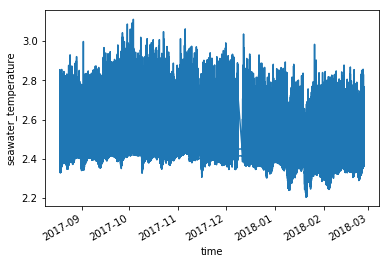

In [20]:
ds['seawater_temperature'].plot()

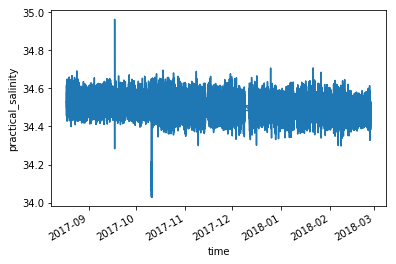

In [18]:
ds['practical_salinity'].plot()

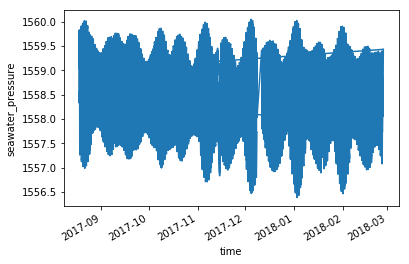

In [19]:
ds['seawater_pressure'].plot()

### Final note

To view all data you have requested under your user, you can go to your user folder on THREDDS

https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/catalog.html

or APACHE

https://opendap.oceanobservatories.org/async_results/ooidatateam@gmail.com/

You do not need to download data from scratch every time you return to a notebook, rather can return to these locations to grab what you have previously downloaded. Data is preserved at these locations for up to 6 months.